# Introduction

For more information and during the exercise there as some good refernce materials:
1. 3D Gaussian Splatting for Real-Time Radiance Field Rendering

https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/3d_gaussian_splatting_low.pdf

2. EWA Volume Splatting:

https://www.cs.umd.edu/~zwicker/publications/EWAVolumeSplatting-VIS01.pdf

During the exercise we will provide more material that covers in details different aspects and theory that we use.

# The Gaussian Rasterizer

In this first section the goal is build a function that takes as input a set of Gaussians in screen-space and renders them using equations in the 3D Gaussian Splatting paper.

Let's remember first the equation of a multi-variate Gaussian:

$a(x) = oe^{-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)}$

where $\mu$ is the mean, or the center of the Gaussian, and $\Sigma$ is it's covariance matrix and $o$ is the opacity value or the amplitude of the Gaussian, in our case this can take values between [0, 1). This equation evaluates the per alpha value of the Gaussian where x is the coordinates of the pixel in screen-space.

To render multiple Gaussians we use the alpha blending as an approximation of the volumetric rendering equation.

$	C(x) = \sum_{i \in \mathcal{N}}c_{i}\alpha_{i}(x)T_i(x)$


where $c_i$ is the color of the Gaussian and transmittance is defined as $T_i(x) = \prod_{j=1}^{i-1}(1-\alpha_{j}(x))$.


The above equations assume that the Gaussians are ordered based on their distance from the camera.



> *Question*:
Why is this ordering important and do you see that ordering in the equation above?






Ordering is important because the transmittance (i.e. the amount of light present till element i) term present in the formula is dependent on the elements present before element i. Unordered elements would disturb this formulation. From what I have read till now, our blending method would work even if the elements (gaussians in our case) are ordered from farthest to nearest.

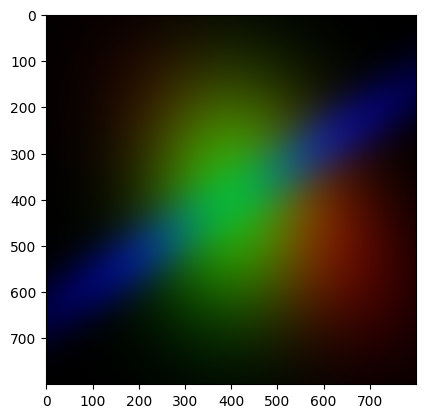

In [1]:
import matplotlib.pyplot as plt
import torch
import math

def get_ndc_range(pixels):
  """Returns the Normalized Device Coordinate (NDC) range  (-1, 1) for given pixels.

  Learn more:
  https://www.khronos.org/opengl/wiki/Coordinate_Transformations
  """
  pixels = pixels
  half_pixels = pixels/2.0

  pixel_space = torch.arange(start=0, end=pixels, step=1.0) + 0.5
  # Bring (0, range) -> (-1, 1)
  ndc_space = (pixel_space - half_pixels)/half_pixels

  return ndc_space

def ndc_pixel_coordinates(width, height):
  """Returns the NDC pixel coordinate, a tensor [H,W,2]

  As input we specific the width and height in pixel dimensions.
  """
  # Make sure width and height are integers even if in float format.
  assert(isinstance(width, int) and isinstance(height, int))


  # NDC space is normalized between (-1, 1) in all 3 dimensions,
  # Pixel coordinates are defined from the center of the pixel hence the + 0.5
  x = get_ndc_range(width)
  y = get_ndc_range(height)
  yy, xx = torch.meshgrid(x, y, indexing='ij')

  # NDC pixel coordinates (H, W, 2)
  ndc_grid = torch.stack([xx, yy], axis=-1)  #in each entry is it (x,y) or (y,x)?
                                              # in my testing it is (y,x)

  return ndc_grid

def z_sort_gaussians(means, covariances, colors, opacities):
  """Sorts based on z a set of gaussians."""

  sorted_indices = torch.argsort(means[:, 2])

  sorted_means = means[sorted_indices]
  sorted_covariances = covariances[sorted_indices]
  sorted_colors = colors[sorted_indices]
  sorted_opacities = opacities[sorted_indices]

  return sorted_means, sorted_covariances , sorted_colors, sorted_opacities

def render_alpha_blend(width, height, means, covariances, colors, opacities):
  """Renders an image from a set of Gaussians with alpha blending.

  Gaussians are assumed to be already in camera-space.
  """

  # Sort the Gaussians based on depth.
  means, covariances, colors, opacities = z_sort_gaussians(means, covariances, colors, opacities)

  # Compute the pixel coodinates of an image in NDC.
  ndc_grid = ndc_pixel_coordinates(width, height) # [H, W, 2]

  # Allocate tensor for the final image
  img = torch.zeros((3, width, height), device=means.device) # [C, H, W]
  # Allocate a helper tensor in which we store the transmittance for each pixel
  T = torch.ones((1, width, height), device=means.device) # [1, H, W]

  for mean, cov, color, opacity in zip(means, covariances, colors, opacities):
    xy_mean = mean[:2]
    d = (ndc_grid - xy_mean[None, None, ...])
    alpha = opacity[None,None,...]*torch.exp(-(1/2.0)*(d[...,None,:] @ torch.linalg.inv(cov) @ d[...,None])).squeeze()
    img += T*alpha*color[...,None,None]
    T = T*(1-alpha)
  return img

# For the sake of testing we make a set of Gaussians
# that are already transformed in Camera-Space

means = torch.tensor([[0.2, 0.0, 1.0],
                      [0.0, 0.0,  0.2],
                      [0.0, 0.0,  0.4]])

covariances = torch.tensor([[[0.2, 0.1],
                             [0.1, 0.2]],

                            [[0.1, 0.0],
                             [0.0, 0.2]],

                            [[0.5, -0.3],
                             [-0.3, 0.2]]])
opacities = torch.tensor([[0.7], [0.7], [0.7]])
colors = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])


image = render_alpha_blend(800, 800, means, covariances, colors, opacities)

plt.imshow(image.permute(1,2,0).cpu().detach())
plt.show()


In [2]:
means = torch.tensor([[-0.2, 0.0, 1.0],
                      [0.0, 0.0,  0.2],
                      [0.0, 0.0,  0.4]])

covariances = torch.tensor([[[0.2, 0.1],
                             [0.1, 0.2]],

                            [[0.1, 0.0],
                             [0.0, 0.2]],

                            [[0.5, -0.3],
                             [-0.3, 0.2]]])
opacities = torch.tensor([[0.7], [0.7], [0.7]])
colors = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

In [3]:
means, covariances, colors, opacities = z_sort_gaussians(means, covariances, colors, opacities)
width, height = 800, 800
  # Compute the pixel coodinates of an image in NDC.
ndc_grid = ndc_pixel_coordinates(width, height) # [H, W, 2]

# Allocate tensor for the final image
img = torch.zeros((3, width, height), device=means.device) # [C, H, W]
# Allocate a helper tensor in which we store the transmittance for each pixel
T = torch.ones((1, width, height), device=means.device) # [1, H, W]

In [4]:
ndc_grid.shape, means.shape, covariances.shape, colors.shape, opacities.shape, img.shape, T.shape

(torch.Size([800, 800, 2]),
 torch.Size([3, 3]),
 torch.Size([3, 2, 2]),
 torch.Size([3, 3]),
 torch.Size([3, 1]),
 torch.Size([3, 800, 800]),
 torch.Size([1, 800, 800]))

In [5]:
mean = means[0]
cov = covariances[0]
color = colors[0]
opacity = opacities[0]

In [6]:
opacity

tensor([0.7000])

In [7]:
xy_mean = mean[:2]
xy_mean

tensor([0., 0.])

In [8]:
d = (ndc_grid - xy_mean[None, None, ...])
ndc_grid[0, 0, :], xy_mean[None, None, ...][0, 0, :], d[0, 0, :]

(tensor([-0.9987, -0.9987]), tensor([0., 0.]), tensor([-0.9987, -0.9987]))

The following is just setting up the stage for evaluation of the terms inside the exponential function.

In [9]:
d[...,None,:].shape, torch.linalg.inv(cov).shape, d[...,None].shape

(torch.Size([800, 800, 1, 2]),
 torch.Size([2, 2]),
 torch.Size([800, 800, 2, 1]))

In [10]:
(opacity[None,None,...]*torch.exp(-(1/2.0)*(d[...,None,:] @ torch.linalg.inv(cov) @ d[...,None]))).shape

torch.Size([800, 800, 1, 1])

In [11]:
alpha = opacity[None,None,...]*torch.exp(-(1/2.0)*(d[...,None,:] @ torch.linalg.inv(cov) @ d[...,None])).squeeze()

In [12]:
color.shape, T.shape, alpha.shape

(torch.Size([3]), torch.Size([1, 800, 800]), torch.Size([1, 800, 800]))

In [13]:
img += T*alpha*color[...,None,None]
img.shape, T.shape, alpha.shape, color[...,None,None].shape

(torch.Size([3, 800, 800]),
 torch.Size([1, 800, 800]),
 torch.Size([1, 800, 800]),
 torch.Size([3, 1, 1]))

In [14]:
image.permute(1,2,0).shape

torch.Size([800, 800, 3])

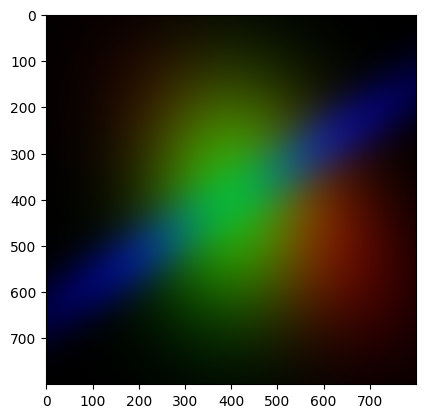

In [15]:
plt.imshow(image.permute(1,2,0).cpu().detach())

# Cameras and 3D Trasnformations

Next, we want to move from the toy examples to real 3-D Transformations.

Our Rendering equation and functions will stay the same, so if they are correct you will not need to change them again. All we need is to define a camera and compute the transformation of a gaussian from world-space to camera-space.

First let's define the matrices related to our camera transformations:

A simplified graphics-based projection matrix because we do not care about the normalization of the z-axis:

$
P = projection\_matrix =
\begin{bmatrix}
\frac{1}{tan(\frac{FoV_x}{2})} & 0 & 0 & 0\\
0 & \frac{1}{tan(\frac{FoV_y}{2})} & 0 & 0\\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$

And a matrix that represents an affine transformation (rotation/translation) and transforms points from world coordinates to view-space coordinates ([0., 0., 0.] at the center of the camera looking into the camera direction):

$
V = world\_to\_view\_matrix =
\begin{bmatrix}
r_{00} & r_{01} & r_{02} & t_{x}\\
r_{10} & r_{11} & r_{12} & t_{y}\\
r_{20} & r_{21} & r_{22} & t_{z} \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$

if $p$ is a point in the world coordinate system them all we need to do to trasnform it in screen space is:

$ p^{tmp} = PVp $

$ p' = [\frac{p^{tmp}_x}{p^{tmp}_w}, \frac{p^{tmp}_y}{p^{tmp}_w}, \frac{p^{tmp}_z}{p^{tmp}_w}, 1]$

where $p'$ is the point in sceen-space coordinates.

**Learn more about tranformations and camera matrices:**

https://learnopengl.com/Getting-started/Camera

https://www.scratchapixel.com/lessons/3d-basic-rendering/perspective-and-orthographic-projection-matrix/building-basic-perspective-projection-matrix.html

In [16]:
def world2view_from_rotation_translation(rotation, translation):
  """Constructs a world to view matrix from rotation and translation."""
  rt = torch.zeros((4, 4))
  rt[:3, :3] = rotation
  rt[:3, 3] = translation
  rt[3, 3] = 1.0
  return rt

def get_projection_matrix(fovx, fovy):
  """Constructs a simplified projection matrix."""
  tan_half_fovy = math.tan((fovy / 2))
  tan_half_fovx = math.tan((fovx / 2))

  proj_mat = torch.zeros([4, 4])

  proj_mat[0, 0] = 1.0/tan_half_fovx
  proj_mat[1, 1] = 1.0/tan_half_fovy
  proj_mat[3, 3] = 1.0
  proj_mat[2, 2] = 1.0

  return proj_mat.type(torch.float32)

def geom_transform_points(points, transf_matrix):
  """Homogeneous transformation of points.

  Args:
    points: [P, 3]
    transf_matrix: [4, 4]

  Returns:
      [P, 3]
  """
  P, _ = points.shape
  ones = torch.ones(P, 1, dtype=points.dtype, device=points.device)
  points_hom = torch.cat([points, ones], dim=1)
  points_out = (transf_matrix @ points_hom[..., None]).squeeze(-1)

  denom = points_out[..., 3:] + 0.0000001
  return (points_out[..., :3] / denom).squeeze(dim=0)


class Camera:
  """Minimal camera class"""

  def __init__(
      self,
      rotation: torch.Tensor,
      translation: torch.Tensor,
      width: int,
      height: int,
      fovy: float,
      fovx: float,
      device: str = "cpu",
  ):
    self.width = width
    self.height = height
    self.fovy = fovy
    self.fovx = fovx

    self.proj_mat = get_projection_matrix(fovx=fovx, fovy=fovy).to(device)

    self.world_view_transform = world2view_from_rotation_translation(
        rotation, translation
    ).to(device)

  def project_points(self, points):
    """Projects points to NDC."""
    return geom_transform_points(points, self.proj_mat @ self.world_view_transform)


# 3D Gaussian Transformations

Our Goal in this section is to trasnform a Gaussian from the world coordinate system to screen-space such that we can use the renderer that we build in the previous sections.

The above 3D trasnformation are part of the standard graphics pipeline but they only hold when we are transforming vertices/points that have no extent.

How can we apply the same ideas to Gaussians that have 3D extent?

We know that the mean of the Gaussian is a dimensionless point so everything that we described can be applied to the mean, but what about the shape of the Gaussian?

When we transform a Gaussian from world coordinate system to screen-space we need to find the new covariance matrix that represents the shape of the Gaussian in screen-space, this is often referred to as "splatting" in the literature.

Let's remember from the lecture:
$\Sigma_{2D} = J_{proj} R \Sigma_{3D}R^TJ_{proj}^T$

$J_{proj}$ is the jacobian of the projection matrix and $R$ is the rotational component of the world to view matrix.

But let's remember why this equation holds and what exactly is describing. First we need to think about how a covariance matrix is changing under and affine/linear transformation. Try to prove to yourself (or open the lecture slides why given a random variable $X$: $Σ(AX) = AΣ(X)A^T$

Now, the pattern becomes obvious, first of all we apply two trasnformations to "our" random variable $X$ which is our Gaussian distribution. The first transformation is a world to view matrix which is affine. Phew! the first one was easy. But the projection matrix is not linear.

> Question #1:
Why the projection matrix is not linear?

>Question #2:
Since we have a linear transformation that includes a rotation and a translation why we only have the rotation in the above equation?


To solve for the non-linear projection matrix, we linearize it by taking the first two terms of the Taylor expansion - that is where the jacobian $J_{proj}$ is coming from - .

If we put both transformations together we get $Σ_{2D}$

In [17]:
def computeJacobian(means, camera):
  # Transform points to camera space
  t = geom_transform_points(means, camera.world_view_transform)
  l = t.norm(dim=1, keepdim=True).flatten()

  # Compute the jacobian according to (29) from EWA Volume Splatting M.Zwicker et. al (2001)
  jacobian = torch.zeros(t.shape[0], 3, 3)
  jacobian[:, 0, 0] = 1/t[:, 2]
  jacobian[:, 0, 2] = -t[:, 0]/t[:, 2]**2
  jacobian[:, 1, 1] = 1/t[:, 2]
  jacobian[:, 1, 2] = -t[:, 1]/t[:, 2]**2
  jacobian[:, 2, 0] = t[:, 0]/l
  jacobian[:, 2, 1] = t[:, 1]/l
  jacobian[:, 2, 2] = t[:, 2]/l

  return jacobian

def covariance_from_3d_to_2d(camera, means, cov3d):

  #h_x = camera.width / (2.0 * math.tan(camera.fovx / 2.0))
  #h_y = camera.height / (2.0 * math.tan(camera.fovy / 2.0))
  h_x = 1.0
  h_y = 1.0

  R = camera.world_view_transform[:3, :3][None, ...]

  J = computeJacobian(means, camera)
  J[:,0] = J[:,0] * h_x
  J[:,1] = J[:,1] * h_y

  cov = J[None, ...] @ R[None, ...] @ cov3d @ R.transpose(1,2)[None, ...] @ J.transpose(1,2)[None, ...] #+ torch.eye(3).cuda() * 0.3

  return cov[0, :,:2,:2]



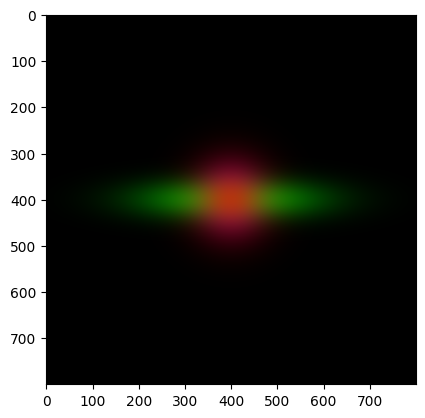

In [18]:
# Let's test this with 3D Gaussians

means_3d = torch.tensor([
    [-0.00, 0.0, 0.01],

    [0.0, 0.0,  0.02],

    [0.0, 0.0,  0.04]
])

cov_3d = torch.tensor([
    [[0.2, 0.0, 0.0],
     [0.0, 0.2, 0.0],
     [0.0, 0.0, 0.2]],

    [[1.0, 0.0, 0.0],
     [0.0, 0.05, 0.0],
     [0.0, 0.0, 0.1]],

    [[0.1, 0.0, 0.0],
     [0.0, 0.1, 0.0],
     [0.0, 0.0, 0.1]]
])

opacities = torch.tensor([[0.7], [0.7], [0.7]])
colors = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

R = torch.eye(3)
T = torch.tensor([0.0, 0.0, -3.0])
camera = Camera(rotation=R, translation=T, width=800, height=800, fovy=0.26, fovx=0.26)

means_2d = camera.project_points(means_3d)
cov2d = covariance_from_3d_to_2d(camera, means_3d, cov_3d)
image = render_alpha_blend(800, 800, means_2d, cov2d, colors, opacities)

plt.imshow(image.permute(1,2,0).cpu().detach())
plt.show()

# Let's render
The next section will render a video with a camera rotating around a circular trajectory always looking at [0.0, 0.0, 0.0]

In [19]:
import imageio
from IPython.display import HTML
from base64 import b64encode

def array_to_video_html(array):
    """
    Converts a NumPy array (frames) into a HTML video tag using imageio
    """
    # Assuming array has shape (frames, height, width, channels)
    imageio.mimwrite('temp.mp4', array, fps=30) # Adjust fps if needed

    video_encoded = b64encode(open('temp.mp4', 'rb').read()).decode()
    return f'<video controls><source type="video/mp4" src="data:video/mp4;base64,{video_encoded}"></video>'

def lookat_to_rt(eye, target, up):
  """Returns the rotation and translation from look-at system of vectors."""
  look_dir = target - eye
  look_dir = look_dir / look_dir.norm()
  right = torch.cross(up, look_dir)
  right = right / right.norm()
  up = torch.cross(look_dir, right)
  up = up / up.norm()

  tx = -torch.dot(eye, right)
  ty = -torch.dot(eye, up)
  tz = -torch.dot(eye, look_dir)

  rotation = torch.tensor([
      [right[0], right[1], right[2]],
      [up[0], up[1], up[2]],
      [look_dir[0], look_dir[1], look_dir[2]],
  ])
  translation = torch.tensor([tx, ty, tz])

  return rotation, translation

def create_cam_from_lookat(
    eye: torch.Tensor,
    target: torch.Tensor,
    up: torch.Tensor,
    width: int,
    height: int,
    fovy: float,
    fovx: float):
  """Creates a camera from a lookat vector system."""
  rotation, translation = lookat_to_rt(eye, target, up)

  return Camera(rotation, translation, width, height, fovy, fovx)

def get_circular_trajectory_around_point(center_point, radius, width, height, fovx, fovy, up = torch.tensor([0.0, -1.0, 0.0]), num_cameras= 150):
  """Returns a list of cameras following a circular trajectory."""
  theta = torch.linspace(0, 2 * math.pi, num_cameras)
  x = radius * torch.sin(theta)
  y = torch.ones_like(x) * 0.0
  z = -radius * torch.cos(theta)
  camera_positions = torch.stack([x, y, z], dim=-1) + center_point
  look_at = center_point

  cameras = []
  for cam_position in camera_positions:
    camera = create_cam_from_lookat(cam_position, look_at, up, width, height, fovy, fovx)
    cameras.append(camera)
  return cameras


cameras = get_circular_trajectory_around_point(torch.tensor([0.0, 0.0, 0.0]), 10.0, 800, 800, 0.26, 0.26, torch.tensor([0.0, 1.0, 0.0]))

imgs = []
for cam in cameras:
  means_2d = cam.project_points(means_3d)
  cov2d = covariance_from_3d_to_2d(cam, means_3d, cov_3d)
  image = render_alpha_blend(800, 800, means_2d, cov2d, colors, opacities)
  imgs.append(image)

frame_list = (255*torch.stack(imgs).permute(0,2,3,1).cpu().detach()).to(torch.uint8)
HTML(array_to_video_html(frame_list))

/tmp/ipykernel_900688/2696168100.py:19: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115765/work/aten/src/ATen/native/Cross.cpp:62.)
  right = torch.cross(up, look_dir)


/home/workbench/anaconda3/envs/learning3d/lib/python3.10/site-packages/imageio/core/util.py:508: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


ValueError: Could not find a backend to open `temp.mp4`` with iomode `wI`.
Based on the extension, the following plugins might add capable backends:
  FFMPEG:  pip install imageio[ffmpeg]
  pyav:  pip install imageio[pyav]